# CS 1656 – Introduction to Data Science 

## Instructor: Xiaowei Jia
### Teaching Assistants: Evangelos Karageorgos, Sonal Gupta


## Term Project 

**Released: April 7, 2022**

**Due: April 26, 2022**

### Goal
The goal of this project is to expose you with a real data science problem, looking at the end-to-end pipeline. 

### What to do 
You are asked to write a Python Jupyter notebook, called `bikes_pgh_data.ipynb` that will:
* [Task 1] access historical bike rental data for 2021 from HealthyRidePGH and summarize the rental data  
* [Task 2] create graphs to show the popularity of the different rental stations, given filter conditions  
* [Task 3] cluster the data to group similar stations together, using a variety of clustering functions and visualize the results of the clustering.  

**Your program should not take more than 15 minutes to run**

### Jupyter Notebook Rules
This skeleton is provided for you to complete the project. Please add your code in the code cells below each Task. Feel free to add cells as needed. Do not remove existing cells.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import glob 
import math
import numpy as np
from datetime import *
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN
from sklearn import cluster
# Feel free to add here any other libraries as specified in the project description

For the sake of interactive display in Jupyter, we will enable matplotlib inline.

In [ ]:
%matplotlib inline

### [Task 0] Warming Up
Task 0 is for testing. It is used to ensure that this Jupyter Notebook skeleton works on both your machines and our machine. Please run the following code to see if you can see a line plot. The line plot is the basic plot that we have seen in Recitation2. 

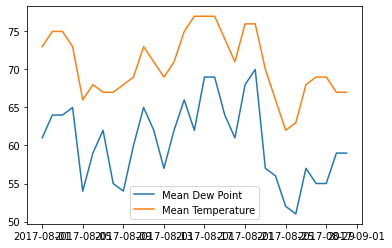

In [ ]:
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
df = pd.read_csv('KPIT_Aug17.csv', sep=',', engine='python', parse_dates=['EST'])
p1 = plt.plot(df['EST'],df['MeanDew PointF'])
p2 = plt.plot(df['EST'],df['Mean TemperatureF'])
plt.legend([p1[0],p2[0]], ['Mean Dew Point', 'Mean Temperature'])

plt.show()

--- 
Add your code below this line

---
### Task 1

In this task you will need to access historical bike rental data for 2021 from HealthyRidePGH and summarize the rental data.

### Task 1.1

In [ ]:
from pandas._libs.algos import diff_2d
def getMonth(x):
    return x.month
def getDay(x):
    return x.day
def getDate(x):
    x = x.split()
    date = pd.Timestamp(x[0])
    return date.date()
def getDateNotTime(x):
    return x.date()
def getHour(x):
    x = x.split()
    hour = pd.Timestamp(x[1])
    return hour.hour
def timetodate(x):
    date = pd.Timestamp(x)
    return date

def calcRebalance(curr):
    row = curr.name
    if row != 0: 
        prev = rebal.iloc[row-1]
        if curr['From station id'] != 0 and prev['To station id'] != 0 and curr['Bikeid'] == prev['Bikeid'] and curr['From station id'] != prev['To station id']:
            return 1

    return 0

df = pd.concat([pd.read_csv(f) for f in glob.glob('HealthyRideRentals2021-*.csv')], ignore_index = True)

# rebalCNT
rebal = df[['Trip id', 'Starttime', 'Bikeid', 'From station id', 'To station id']].copy()
rebal['Startdate'] = pd.to_datetime(rebal['Starttime']).dt.date
rebal = rebal.sort_values(by=['Bikeid', 'Startdate'])
rebal = rebal[rebal.groupby(['Bikeid'])['Bikeid'].transform('size') > 1]
rebal = rebal.reset_index(drop=True)
rebal['Rebal'] = rebal.apply(calcRebalance, axis=1)

# fromCNT
fro = rebal[['Startdate', 'Bikeid', 'From station id']].copy()

fro = fro[fro.groupby(['Bikeid'])['Bikeid'].transform('size') > 1]
fro = fro.reset_index(drop=True)

# toCNT
to = rebal[['Startdate', 'Bikeid', 'To station id']].copy()
to = to[to.groupby(['Bikeid'])['Bikeid'].transform('size') > 1]
to = to.reset_index(drop=True)

rebalp = pd.pivot_table(rebal,index=['Startdate', 'From station id'], values=['Rebal'], aggfunc='sum')
rebalCNT = rebalp.reset_index()
rebalCNT.columns = ['Day', 'StationID', 'rebalCNT']

fromp = pd.pivot_table(fro,index=['Startdate', 'From station id'], values=['From station id'],aggfunc=lambda x: len(x))
fromCNT = fromp.reset_index()
fromCNT.columns = ['Day', 'StationID', 'fromCNT']

top = pd.pivot_table(to,index=['Startdate', 'To station id'], values=['To station id'],aggfunc=lambda x: len(x))
toCNT = top.reset_index()
toCNT.columns = ['Day', 'StationID', 'toCNT']

rebalCNT = rebalCNT.sort_values(by=['Day', 'StationID'])
fromCNT = fromCNT.sort_values(by=['Day', 'StationID'])
toCNT = toCNT.sort_values(by=['Day', 'StationID'])

fT = fromCNT.merge(toCNT, how='outer', on=['Day', 'StationID'])
fT = fT.fillna(0)
fT = fT.sort_values(by=['Day', 'StationID'])


df_final = pd.merge(fT, rebalCNT, how='outer', on=['Day', 'StationID'])
df_final = df_final.fillna(0)

df_final.head(20)

,Day,StationID,fromCNT,toCNT,rebalCNT
0,2021-01-01,1002.0,1.0,1.0,0.0
1,2021-01-01,1010.0,1.0,0.0,0.0
2,2021-01-01,1017.0,0.0,2.0,0.0
3,2021-01-01,1024.0,1.0,1.0,0.0
4,2021-01-01,1028.0,1.0,1.0,0.0
5,2021-01-01,1032.0,1.0,0.0,0.0
6,2021-01-01,1039.0,0.0,1.0,0.0
7,2021-01-01,1059.0,1.0,1.0,0.0
8,2021-01-01,1062.0,2.0,2.0,0.0
9,2021-01-01,1094.0,2.0,0.0,0.0


### Task 1.2

In [ ]:
monthly = df_final.copy()
print(df_final.keys())
monthly = monthly.copy()
monthly.columns = ['Month','Station ID',"fromCNT","toCNT",'rebal']
monthly['Month'] = monthly['Month'].apply(getMonth)

monthly = monthly.groupby(["Month","Station ID"]).sum().reset_index()

monthly.head(20)

Index(['Day', 'StationID', 'fromCNT', 'toCNT', 'rebalCNT'], dtype='object')


,Month,Station ID,fromCNT,toCNT,rebal
0,1,1000.0,23.0,29.0,2.0
1,1,1001.0,18.0,27.0,0.0
2,1,1002.0,27.0,27.0,3.0
3,1,1003.0,2.0,1.0,0.0
4,1,1004.0,20.0,16.0,3.0
5,1,1005.0,6.0,3.0,0.0
6,1,1006.0,8.0,8.0,1.0
7,1,1007.0,9.0,7.0,1.0
8,1,1009.0,8.0,3.0,0.0
9,1,1010.0,47.0,30.0,12.0


---
### Task 2

In this task you will need to create graphs to show the popularity of the different rental stations, given filter conditions.

In [ ]:
# FILTER VARIABLES -- feel free to edit the values, but the names of the variables must remain 
#                     as they are and should be used by your code accordingly from this point on

filter_month = 4
filter_stationID = 1046
num_to_month = {1:['January', 31], 2:['February', 28], 3:['March', 31], 4:['April', 30], 
                5:['May', 31], 6:['June', 30], 7:['July', 31], 8:['August', 31], 9:['September', 30], 
                10:['October', 31], 11:['November', 30], 12:['December', 31]}


### Task 2.1

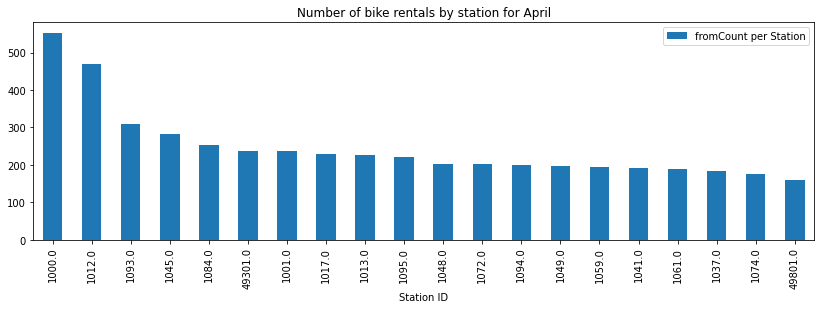

In [ ]:
df['From Date'] = df['Starttime'].apply(getDate)
df['To Date'] = df['Starttime'].apply(getDate)

data_small = df[['From Date','From station id', 'Trip id', 'Bikeid', 'To station id', 'To Date']].copy() 
month = data_small[['From Date','From station id']].copy()

month.columns = ['Date','Station ID']
month = month.sort_values('Station ID')
indexNames = month[month['Station ID'] == 0].index
month.drop(indexNames , inplace=True)

month['Date'] = month['Date'].apply(getMonth)

month = month.loc[month['Date'] == filter_month]
month = month['Station ID'].groupby([month['Station ID']]).count()
month = month.sort_values(ascending=False)
keys = month.keys()
counts = month.tolist()

a = pd.DataFrame({'Station ID':keys[0:20], 'fromCount per Station':counts[0:20]})
p = a.plot.bar(x='Station ID', y='fromCount per Station', title='Number of bike rentals by station for April', figsize=(14,4))

### Task 2.2

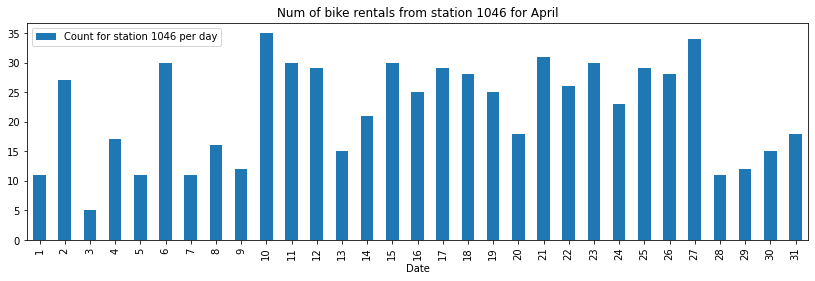

In [ ]:
station = data_small[["From Date", 'From station id']].copy()
station.columns = ['Date','Station ID']

station['Date'] = station['Date'].apply(getDay)
station = station.sort_values('Date')
station = station.loc[station['Station ID'] == filter_stationID]
station = station['Date'].groupby([station['Date']]).count()
keys = station.keys()

counts = station.tolist()
for i in range(1, num_to_month[filter_month][1] + 1):
    if i not in keys:
        keys = keys.insert(i - 1, i)
        counts.insert(i - 1, 0)

df = pd.DataFrame({'Date':keys, 'Count for station 1046 per day':counts})
p = df.plot.bar(x='Date', y='Count for station 1046 per day', title='Num of bike rentals from station 1046 for April' , figsize=(14,4))

### Task 2.3

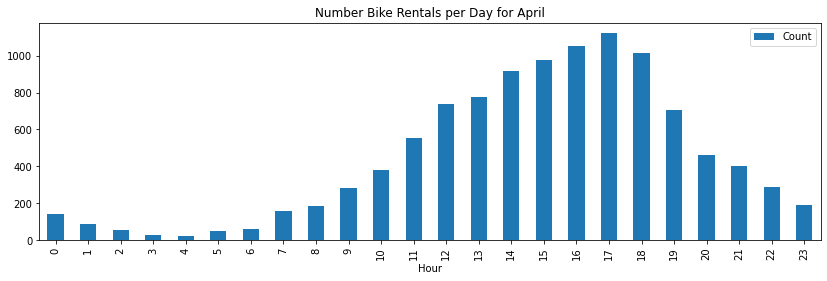

In [ ]:
hour =  rebal[['Starttime',"Starttime",'From station id']].copy()

hour.columns = ["Month",'Hour','Station ID']
hour["Hour"] = hour["Hour"].apply(getHour)
hour['Month'] = hour['Month'].apply(getDate)
hour['Month'] = hour['Month'].apply(getMonth)
hour = hour.loc[hour['Month'] == filter_month]
hour = hour.groupby([hour['Hour']]).count().reset_index()

keys = hour.keys()
counts = hour.values.tolist()

p = hour.plot.bar(x='Hour', y='Station ID', title="Number Bike Rentals per Day for April", figsize=(14,4))
p.legend(["Count"])


### Task 2.4

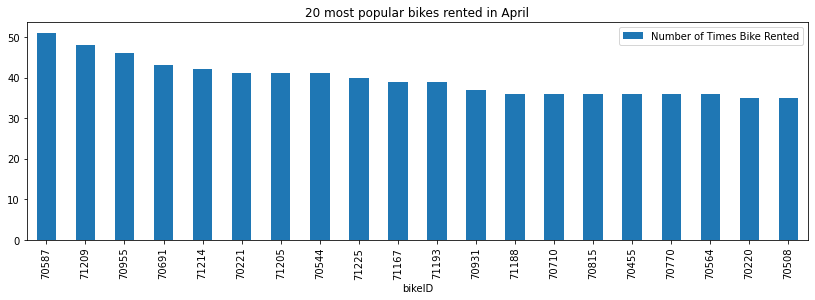

In [ ]:
bike = data_small[['From Date','Bikeid']].copy()

bike.columns = ['Date','Bikeid']

bike['Date'] = bike['Date'].apply(getMonth)

bike = bike.loc[bike['Date'] == filter_month]
bike = bike.groupby(['Bikeid'])['Bikeid'].count()
bike = bike.sort_values(ascending= False)

keys = bike.keys()
counts = bike.tolist()

df = pd.DataFrame({'bikeID':keys[0:20], 'Number of Times Bike Rented':counts[0:20]})
p = df.plot.bar(x='bikeID', y='Number of Times Bike Rented', title='20 most popular bikes rented in April', figsize=(14,4))

---
### Task 3

In this task you will cluster the data to group similar stations together, using a variety of clustering functions and visualize the results of the clustering.

### Task 3.1

In [19]:
#I literally can not figure out this method -- I am giving up :? :(
#I think I set this problem up correctly but I could not figure out how to complete the graphs 
#I was able to make the elbow graph off of this set up which I put in task 3.3 
sixes = monthly.copy()

sixes = sixes.loc[100:600]
sixes.drop('toCNT', axis=1, inplace=True)

six4 = sixes.loc[400:500]
six4.columns = ['Month','Station ID',"fromCNT4","rebalCNT4"]

six5 = sixes.loc[500:600]
six5.columns = ['Month','Station ID',"fromCNT5","rebalCNT5"]

six6 = sixes.loc[550:650]
six6.columns = ['Month','Station ID',"fromCNT6","rebalCNT6"]

allsixes = six4.merge(six5,how = "outer", on = "Station ID").merge(six6,how = "outer", on ="Station ID")
allsixes.drop('Month_x', axis=1, inplace=True)
allsixes.drop('Month_y', axis=1, inplace=True)
allsixes.drop('Month', axis=1, inplace=True)
allsixes = allsixes.fillna(0)

allsixes = allsixes[['Station ID','fromCNT4', 'fromCNT5', 'fromCNT6', 'rebalCNT4', 'rebalCNT5', 'rebalCNT6']]

allsixes.set_index("Station ID")

parameters = [1,2,3,4,5,6]
for i in range (0, 3):
    kmeans = KMeans(n_clusters=parameters[i], init='k-means++', random_state=5000).fit(allsixes)


### Task 3.2

In [20]:
#Could not figure this out

### Task 3.3

I could not figure out 3.1 or 3.2 completly, but here is the elbow method graph that I have created. According to the elbow graph, I think the optimal K would be 3 because it is right after or as the graph evens out.

I completed the elbow graph below. I tried to go to office hours with the professor on thursday, and he suggested I go to the TA office hours on friday, but I went and they were not occurring. Then, I wanted to ask about output because I had to rework task 1.1 and I was not able to get in contact with anyone. :( 

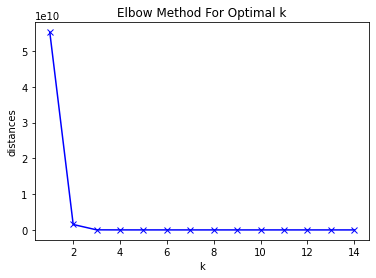

In [21]:
distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k,init='k-means++', random_state=5000)
    km = km.fit(allsixes)
    distances.append(km.inertia_)
    
plt.plot(K,distances, 'bx-')
plt.xlabel('k')
plt.ylabel('distances')
plt.title('Elbow Method For Optimal k')
plt.show()